In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
import numpy as np

In [2]:
df = pd.read_parquet("https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/final_gpu_time_windows.parquet")
df.groupby(["app_name", "label"]).size()
df.head()

,pid,comm,uid,gid,ppid,user_pid,user_ppid,cgroup_id,cgroup_name,user,...,memcpy_rate,alloc_rate,wall_time_dt,wall_time_ms,container_id,container_image,container_labels_json,app_name,label,experiment_time
0,64666,hashcat,0,0,0,0,0,0,,,...,4.0,0.0,2025-11-11 22:31:33.200000+00:00,1762900293200,,,{},passwd_hashcat,1,20251111T222850Z
1,64666,hashcat,0,0,0,0,0,0,,,...,0.0,0.0,2025-11-11 22:31:36.994000+00:00,1762900296994,,,{},passwd_hashcat,1,20251111T222850Z
2,64417,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:41.469000+00:00,1762900121469,,,{},passwd_hashcat,1,20251111T222850Z
3,64443,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:45.610000+00:00,1762900125610,,,{},passwd_hashcat,1,20251111T222850Z
4,64469,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:48.582000+00:00,1762900128582,,,{},passwd_hashcat,1,20251111T222850Z


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   pid                     2946 non-null   uint32             
 1   comm                    2946 non-null   object             
 2   uid                     2946 non-null   uint32             
 3   gid                     2946 non-null   uint32             
 4   ppid                    2946 non-null   uint32             
 5   user_pid                2946 non-null   uint32             
 6   user_ppid               2946 non-null   uint32             
 7   cgroup_id               2946 non-null   uint64             
 8   cgroup_name             2946 non-null   object             
 9   user                    2946 non-null   object             
 10  window_start_ns         2946 non-null   int64              
 11  window_end_ns           2946 non-null   int

In [4]:
df.isna().sum()

pid                       0
comm                      0
uid                       0
gid                       0
ppid                      0
user_pid                  0
user_ppid                 0
cgroup_id                 0
cgroup_name               0
user                      0
window_start_ns           0
window_end_ns             0
kernel_launch_count       0
mem_alloc_count           0
memcpy_count              0
stream_sync_count         0
avg_threads_per_kernel    0
max_threads_per_kernel    0
avg_blocks_per_kernel     0
total_threads_launched    0
total_mem_alloc_bytes     0
avg_mem_alloc_bytes       0
total_memcpy_bytes        0
avg_memcpy_bytes          0
htod_bytes                0
dtoh_bytes                0
htod_ratio                0
avg_sync_time_ns          0
max_sync_time_ns          0
sync_fraction             0
launch_rate               0
memcpy_rate               0
alloc_rate                0
wall_time_dt              0
wall_time_ms              0
container_id        

In [5]:
counts = df["label"].value_counts()
print(counts)

# Or more descriptive:
print("Benign (0):", counts.get(0, 0))
print("Malign (1):", counts.get(1, 0))
print("Total:", len(df))

label
0    1811
1    1135
Name: count, dtype: int64
Benign (0): 1811
Malign (1): 1135
Total: 2946


In [6]:
counts = df["app_name"].value_counts()
print(counts)

app_name
llm_gpt_neo       754
miner_xmrig       679
passwd_hashcat    456
ml_svm            241
llm_gpt           190
llm_bert          132
dl_lstm_train     131
dl_cnn_train      109
blender            98
llm_roberta        85
ml_logreg          46
ml_forest          25
Name: count, dtype: int64


In [7]:
df["experiment_id"] = df["app_name"].astype(str) + "_" + df["experiment_time"].astype(str)

In [8]:
drop_cols = [
    "pid", "uid", "gid", "ppid", "user_pid", "user_ppid",
    "cgroup_id", "cgroup_name", "user",
    "container_id", "container_image", "container_labels_json",
    "experiment_time", "wall_time_dt", "wall_time_ms", "window_start_ns", "window_end_ns"
]
df = df.drop(columns=drop_cols, errors="ignore")


In [9]:
X = df.drop(columns=["label", "app_name", "comm", "experiment_id", "label"])
y = df["label"]
groups = df["experiment_id"]

In [10]:
scaler = StandardScaler()
num_cols = X.select_dtypes(include=["float64", "int64", "uint64", "uint32"]).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

In [12]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 2475
Test size : 471


In [13]:
svm = make_pipeline(
    StandardScaler(),
    LinearSVC(C=1.0, class_weight="balanced", random_state=42)
)
svm.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('linearsvc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001


In [14]:
y_scores = svm.decision_function(X_test)
y_pred = svm.predict(X_test)

acc = svm.score(X_test, y_test)
auc = roc_auc_score(y_test, y_scores)

print("\n=== RESULTS ===")
print(f"Accuracy : {acc:.4f}")
print(f"AUC      : {auc:.4f}")
print(classification_report(y_test, y_pred))


=== RESULTS ===
Accuracy : 0.9830
AUC      : 0.9985
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       392
           1       0.93      0.97      0.95        79

    accuracy                           0.98       471
   macro avg       0.96      0.98      0.97       471
weighted avg       0.98      0.98      0.98       471



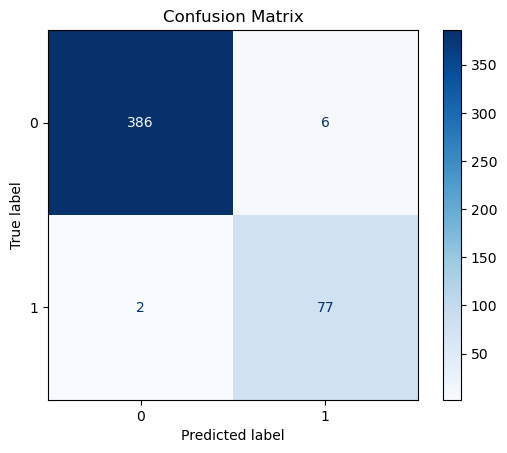

In [15]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

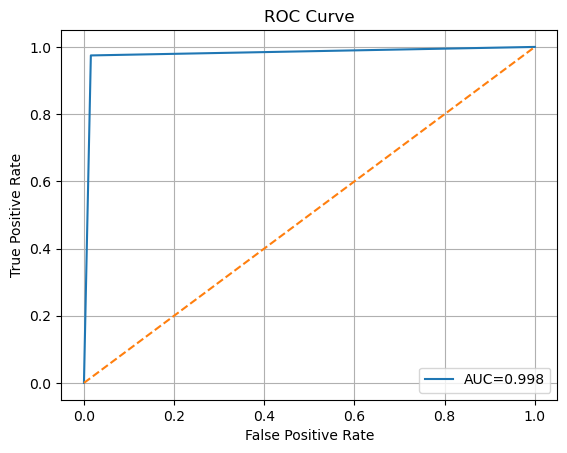

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_26282/75746852.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


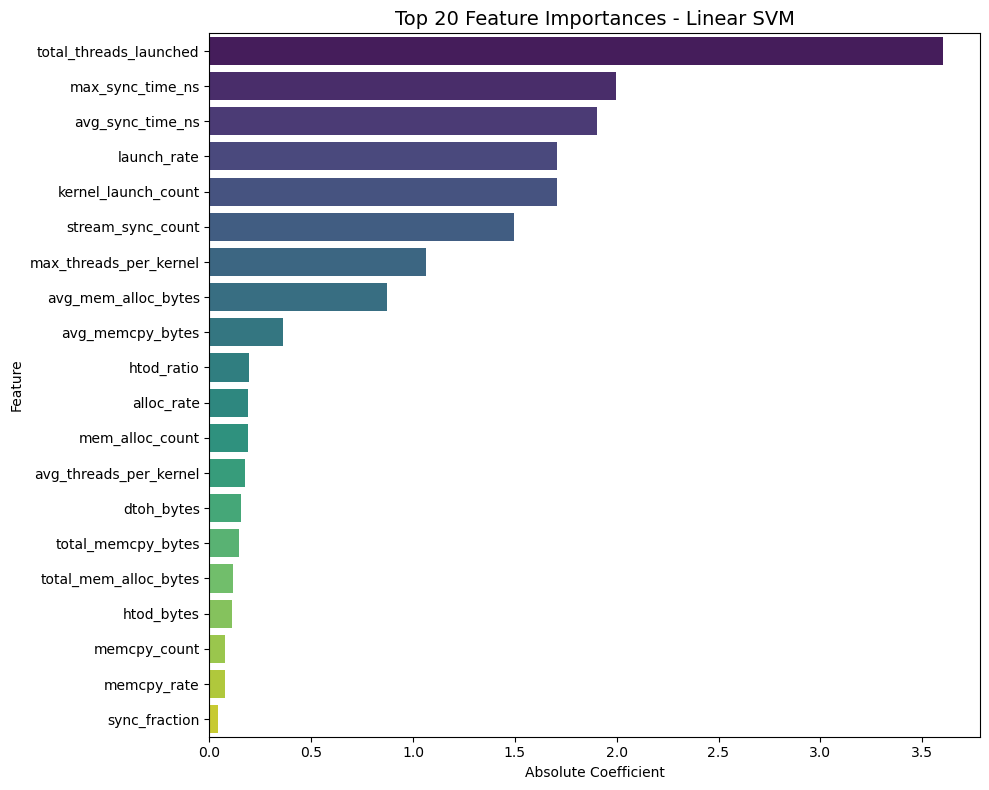

In [17]:
svc = svm.named_steps["linearsvc"]

feature_names = X.columns
coefficients = svc.coef_[0]

importances = pd.Series(abs(coefficients), index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    y=importances.index[:20],
    x=importances.values[:20],
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Linear SVM", fontsize=14)
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [18]:
def evaluate_dataset(df_test, svm, train_features, label_for_dataset):
    drop_cols = [
        "pid", "uid", "gid", "ppid", "user_pid", "user_ppid",
        "cgroup_id", "cgroup_name", "user",
        "container_id", "container_image", "container_labels_json",
        "experiment_time", "wall_time_dt", "wall_time_ms",
        "window_start_ns", "window_end_ns",
    ]

    # Clean the dataframe
    df_test_clean = df_test.drop(columns=drop_cols, errors="ignore")

    # Use only training features
    df_test_clean = df_test_clean[train_features]

    # SVM pipeline handles scaling internally (DO NOT SCALE HERE)
    y_pred = svm.predict(df_test_clean)
    y_scores = svm.decision_function(df_test_clean)

    print(y_pred)

    # Add the known label
    y_true = np.full(len(y_pred), label_for_dataset)

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    print("\n==============================")
    print(" EVALUATION FOR DATASET")
    print("==============================")
    print("Label:", "Malign (1)" if label_for_dataset == 1 else "Benign (0)")
    print(f"Samples: {len(y_true)}")
    print("Accuracy:", accuracy)
    print("TP:", tp)
    print("FP:", fp)
    print("TN:", tn)
    print("FN:", fn)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "y_scores": y_scores,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn,
    }

In [19]:
df_malign = pd.read_parquet(
    "https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset_test/lolminer/audit_gpu_time_window_events.parquet"
)

results_malign = evaluate_dataset(
    df_test=df_malign,
    svm=svm,
    train_features=X_train.columns,
    label_for_dataset=1
)

[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]

 EVALUATION FOR DATASET
Label: Malign (1)
Samples: 45
Accuracy: 0.13333333333333333
TP: 6
FP: 0
TN: 0
FN: 39

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.13      0.24        45

    accuracy                           0.13        45
   macro avg       0.50      0.07      0.12        45
weighted avg       1.00      0.13      0.24        45



/home/aleyi/miniconda3/envs/infrasight-ml/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aleyi/miniconda3/envs/infrasight-ml/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aleyi/miniconda3/envs/infrasight-ml/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [20]:
df_benign = pd.read_parquet(
    "https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset_test/llm_blom/audit_gpu_time_window_events.parquet"
)

results_benign = evaluate_dataset(
    df_test=df_benign,
    svm=svm,
    train_features=X_train.columns,
    label_for_dataset=0
)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]

 EVALUATION FOR DATASET
Label: Benign (0)
Samples: 79
Accuracy: 1.0
TP: 0
FP: 0
TN: 79
FN: 0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

